In [26]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
import matplotlib.dates as mdates
from keras.layers import Dense,Dropout
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from keras.layers import GRU

In [39]:
df_bnb = pd.read_csv('BNB2019-2024.csv')
df_bnb.info()
df_bnb.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1815 non-null   int64  
 1   Date        1815 non-null   object 
 2   Open        1815 non-null   float64
 3   High        1815 non-null   float64
 4   Low         1815 non-null   float64
 5   Close       1815 non-null   float64
 6   Adj Close   1815 non-null   float64
 7   Volume      1815 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 113.6+ KB


,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
1810,1810,2024-02-13,327.932404,329.205780,319.484406,324.868225,324.868225,886487720
1811,1811,2024-02-14,324.865570,334.369141,323.876587,334.245972,334.245972,887463520
1812,1812,2024-02-15,334.210876,365.133118,333.852997,354.710815,354.710815,1744161787
1813,1813,2024-02-16,354.687561,365.562073,351.701599,360.890381,360.890381,1461675119
1814,1814,2024-02-17,360.872955,363.248718,355.231720,356.580414,356.580414,1298804608


In [46]:
target_data_bnb = df_bnb[['Close']]
target_data_bnb.head()

,Close
0,11.393217
1,11.869744
2,11.537903
3,11.545945
4,13.811967


In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
target_data_bnb  = scaler.fit_transform(target_data_bnb)

In [48]:
# Create training set
test_len  = int(0.2*len(target_data_bnb))
train_len = int(0.8*len(target_data_bnb))
timesteps = 363
features  = 1

X_train_bnb = []
y_train_bnb = []

for i in range(timesteps, train_len):
  X_train_bnb.append(target_data_bnb[i-timesteps:i, :])
  y_train_bnb.append(target_data_bnb[i, :])

X_train_bnb = np.asarray(X_train_bnb)
y_train_bnb = np.asarray(y_train_bnb)

# Reshaping
X_train_bnb = np.reshape(X_train_bnb, (X_train_bnb.shape[0], X_train_bnb.shape[1], 1))
print(X_train_bnb.shape, y_train_bnb.shape)

(1089, 363, 1) (1089, 1)


In [49]:
X_test_bnb = []
y_test_bnb = []

for i in range(train_len, target_data_bnb.shape[0]):
  X_test_bnb.append(target_data_bnb[i-timesteps:i, :])
  y_test_bnb.append(target_data_bnb[i, :])

X_test_bnb = np.asarray(X_test_bnb)
y_test_bnb = np.asarray(y_test_bnb)

print(X_test_bnb.shape, y_test_bnb.shape)

(363, 363, 1) (363, 1)


In [51]:
# The GRU architecture
model_GRU = Sequential()
# First GRU layer with Dropout regularisation
model_GRU.add(GRU(50, return_sequences=True, input_shape=(X_train_bnb.shape[1],1), activation='tanh'))
model_GRU.add(Dropout(0.2))
# Second GRU layer
model_GRU.add(GRU(50, return_sequences=True, activation='tanh'))
model_GRU.add(Dropout(0.2))
# Third GRU layer
model_GRU.add(GRU(50, return_sequences=True, activation='tanh'))
model_GRU.add(Dropout(0.2))
# Fourth GRU layer
model_GRU.add(GRU(50, activation='tanh'))
model_GRU.add(Dropout(0.2))
# The output layer
model_GRU.add(Dense(1))

In [52]:
optimizer=SGD(learning_rate=0.01, momentum=0.9)

In [53]:
# Compiling model
model_GRU.compile(optimizer= optimizer,loss='mean_squared_error')
# Fitting to the training set
model_GRU.fit(X_train_bnb,y_train_bnb,epochs=50,batch_size=150)

Epoch 1/50
8/8 [==============================] - 19s 1s/step - loss: 0.1180
Epoch 2/50
8/8 [==============================] - 12s 2s/step - loss: 0.0796
Epoch 3/50
8/8 [==============================] - 11s 1s/step - loss: 0.0528
Epoch 4/50
8/8 [==============================] - 11s 1s/step - loss: 0.0345
Epoch 5/50
8/8 [==============================] - 11s 1s/step - loss: 0.0194
Epoch 6/50
8/8 [==============================] - 11s 1s/step - loss: 0.0088
Epoch 7/50
8/8 [==============================] - 10s 1s/step - loss: 0.0061
Epoch 8/50
8/8 [==============================] - 11s 1s/step - loss: 0.0054
Epoch 9/50
8/8 [==============================] - 11s 1s/step - loss: 0.0056
Epoch 10/50
8/8 [==============================] - 11s 1s/step - loss: 0.0056
Epoch 11/50
8/8 [==============================] - 11s 1s/step - loss: 0.0051
Epoch 12/50
8/8 [==============================] - 10s 1s/step - loss: 0.0055
Epoch 13/50
8/8 [==============================] - 11s 1s/step - loss: 0.

In [54]:
y_pred_bnb_GRU = model_GRU.predict(X_test_bnb)
y_pred_bnb_GRU = scaler.inverse_transform(y_pred_bnb_GRU)
y_test_bnb_GRU = scaler.inverse_transform(y_test_bnb)

12/12 [==============================] - 4s 221ms/step


In [55]:
# Calculate RMSE
rmse = np.sqrt(np.mean(((y_pred_bnb_GRU - y_test_bnb_GRU) ** 2)))
print('Root Mean Squared Error:', rmse)

# Calculate MAPE
mape = np.mean(np.abs((y_test_bnb_GRU - y_pred_bnb_GRU) / y_test_bnb_GRU))
print('Mean Absolute Percentage Error (MAPE):', mape)

## Calculate MSE
mse = np.mean((y_pred_bnb_GRU - y_test_bnb_GRU) ** 2)
print('Mean Squared Error:', mse)

Root Mean Squared Error: 12.979621451463029
Mean Absolute Percentage Error (MAPE): 0.030905225649883128
Mean Squared Error: 168.47057302327923


In [56]:
# 13. Dự báo 90 ngày tiếp theo
from numpy import array

x_input = X_test_bnb[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        # Lấy đúng 100 phần tử cuối cùng
        x_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        # Dự đoán giá trị tiếp theo
        yhat = model_GRU.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        # Thêm giá trị dự đoán vào danh sách
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model_GRU.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.36338813 0.36274506 0.36325421 0.35757867 0.34811602 0.3495097
 0.36675674 0.35025292 0.35323429 0.35354256 0.35599945 0.36657625
 0.3258307  0.340314   0.33675585 0.33545785 0.33776761 0.3341765
 0.32723409 0.3306432  0.32711594 0.3276278  0.32892126 0.33005469
 0.32824974 0.3360497  0.33299709 0.33024014 0.33557263 0.34448539
 0.34276336 0.34571182 0.35574894 0.36786681 0.36475761 0.36643537
 0.35346403 0.35264237 0.34507417 0.34813608 0.36507858 0.37629004
 0.39300811 0.39320309 0.3932248  0.38320847 0.38674482 0.43270004
 0.47169776 0.47158018 0.45699175 0.46192565 0.45482597 0.4577865
 0.45432788 0.46116786 0.4715817  0.46235201 0.44786031 0.4405003
 0.44291643 0.43762707 0.44381158 0.44922158 0.431105   0.43950489
 0.43473831 0.46252757 0.45901412 0.44979772 0.45611245 0.45762464
 0.46161676 0.46365535 0.44432213 0.43376663 0.42579351 0.42403432
 0.43964101 0.44490418 0.44362965 0.452233   0.4473624  0.436689
 0.4364261  0.43789551 0.43576697 0.44326727 0.43744386 

In [57]:
df_bnb1 = df_bnb.reset_index()['Close']
scaler=MinMaxScaler(feature_range=(0,1))
df_bnb1=scaler.fit_transform(np.array(df_bnb1).reshape(-1,1))

In [58]:
train_data = df_bnb1[:train_len]
test_data = df_bnb1[train_len:train_len+test_len]


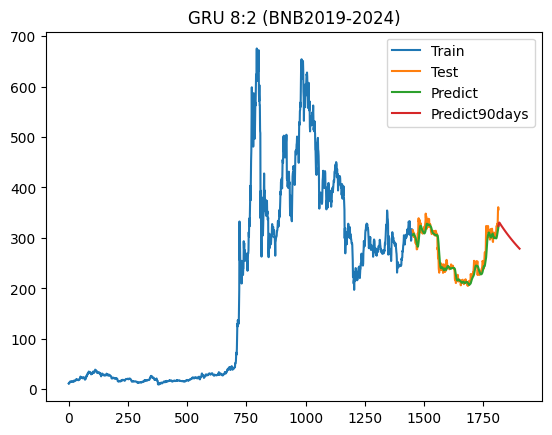

In [59]:
plt.title('GRU 8:2 (BNB2019-2024)')
train_data_index = pd.RangeIndex(start=0, stop=train_len, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_len, stop=train_len+test_len, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_len, stop=train_len+test_len, step=1)
plt.plot(test_data_index,(y_pred_bnb_GRU))
prediect_data_index = pd.RangeIndex(start=len(df_btc)-1, stop=len(df_btc)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict90days'])
plt.show()